In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import warnings
import matplotlib
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms as transforms
import os
from torchvision import datasets
from utils import *
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
%matplotlib inline
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
warnings.filterwarnings('ignore')
matplotlib.use('Agg')
from PIL import Image

# import all the dropout methods
from drops_methods.resnet_model import ResNet18
from drops_methods.resnet_dropout import ResNet18_Dropout
from drops_methods.resnet_concrete import ResNet18_Concrete
from drops_methods.resnet_variational import ResNet18_Variational
from drops_methods.resnet_dropblock import ResNet18_DropBlock
from drops_methods.resnet_shakedrop import ShakePyramidNet


/home-sipl/prj7739/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home-sipl/prj7739/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.cuda.empty_cache()

# Setting fixed seeds
seed = 48 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

In [3]:
#Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Defining hyper-parameters
hparams = Hyper_Params()
hparams.lr =  0.005
hparams.momentum = 0.9 # in the SGDM algorithm, we use momentum to accelrate convergence by adding a fraction of the previous gradient step, thus overcome local minima and oscillations. 
hparams.weight_decay = 1e-4
hparams.dropout_probability = 0.0
hparams.epochs = 100
hparams.batch_size = 64
hparams.scheduler_step_size = 10# the number of epochs between each scheduler step 
hparams.scheduler_factor = 0 # the factor by which the scheduler changes the learning rate 
hparams.train_dic = f'../dataset/train'
hparams.test_dic = f'../dataset/test'



dropout_methods = {
    'Original': [0.0],
    'Dropout': [0.05, 0.1, 0.3, 0.5, 0.6],
    'Concrete': [1e-3, 1e-4, 1e-5], # [0.0], # l_values = [1e-3, 1e-4, 1e-5]
    'Variational': [(-8,2),(-8,3),(-8,4),(-10,2),(-10,3),(-10,4),(-12,2),(-12,3),(-12,4)], #[0.0], # log_sigma2 = [-8, -10, -12], threshold = [2, 3, 4, 5]   
    'DropBlock': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6],  
    'DropShake': [0.3, 0.5, 0.7, 1.0]
}

# Dictionary to save results
best_results = {}
best_test_acc = []
best_drop_rate = 0.0

In [4]:
train_transform = transforms.Compose([
    Resize((48, 48)),
    ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    Resize((48,48)),
    ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
train = datasets.ImageFolder(hparams.train_dic, transform=train_transform)
test = datasets.ImageFolder(hparams.test_dic, transform=test_transform)

# Create Validation set
val_split_ratio = 0.2  # 20% for validation
total_size = len(train)
val_size = int(val_split_ratio * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(train, [train_size, val_size])

classes = train.classes
print(f"Class labels: {classes}")
class_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=hparams.batch_size, num_workers=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hparams.batch_size, num_workers=1, shuffle=False)
test_loader = DataLoader(test, batch_size=hparams.batch_size, num_workers=1, shuffle=False)

# for Concrete Dropout
N = len(train_loader.dataset)

**************************************************
* Dropout method: Original  |  dropout rate: 0.0 *
**************************************************
Epoch [1/100]  |  Train Loss: 1.5906, Train Accuracy: 38.08%  |  Validation Loss: 1.4483, Validation Accuracy: 43.81%
----------------------------------------------------------------------------------------------------------
Epoch [2/100]  |  Train Loss: 1.3388, Train Accuracy: 48.84%  |  Validation Loss: 1.3326, Validation Accuracy: 47.62%
----------------------------------------------------------------------------------------------------------
Epoch [3/100]  |  Train Loss: 1.1811, Train Accuracy: 55.68%  |  Validation Loss: 1.2568, Validation Accuracy: 52.26%
----------------------------------------------------------------------------------------------------------
Epoch [4/100]  |  Train Loss: 1.0465, Train Accuracy: 60.86%  |  Validation Loss: 1.2984, Validation Accuracy: 53.54%
------------------------------------------------------

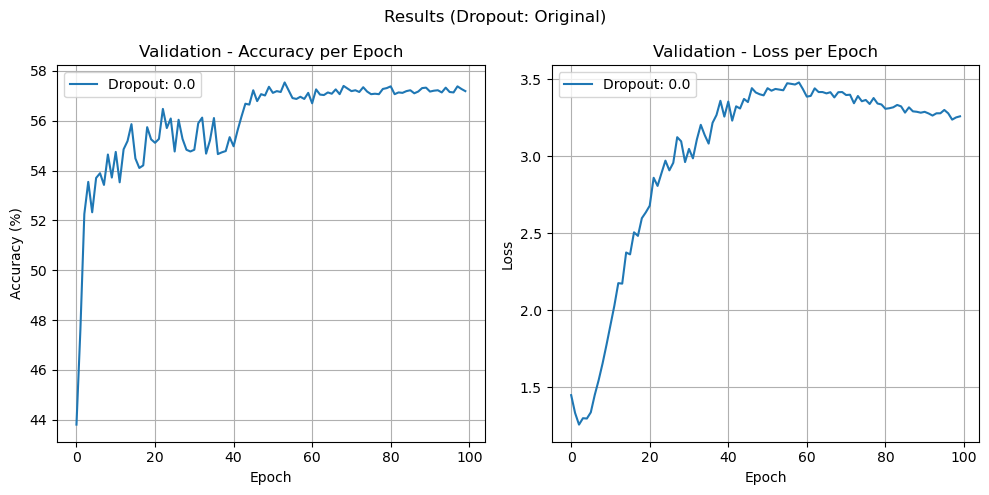

No Dropout Results {'dropout_rate': 0.0, 'validation_accuracy': [43.807699007141615, 47.6223654415607, 52.255704581083435, 53.54467862741683, 52.32537885385821, 53.70144574116008, 53.89304999129072, 53.42274865006097, 54.64204842361958, 53.71886430935377, 54.74655983278175, 53.52726005922313, 54.85107124194391, 55.18202403762411, 55.861348197178195, 54.48528130987633, 54.10207280961505, 54.206584218777216, 55.73941821982233, 55.251698310398886, 55.11234976484933, 55.26911687859258, 56.4709980839575, 55.70458108343494, 56.08778958369622, 54.76397840097544, 56.035533879115135, 55.26911687859258, 54.833652673750215, 54.76397840097544, 54.833652673750215, 55.89618533356558, 56.12262672008361, 54.676885560006966, 55.2168611740115, 56.10520815188991, 54.659466991813275, 54.72914126458805, 54.78139696916914, 55.33879115136736, 54.973001219299775, 55.600069674272774, 56.157463856471, 56.68002090228183, 56.645183765894444, 57.21999651628636, 56.784532311443996, 57.06322940254311, 57.01097369796

In [7]:
%matplotlib inline
best_val_acc, best_drop_rate = train_and_evaluate(ResNet18, dropout_methods['Original'], train_loader, val_loader, criterion, hparams, drop_method='Original')
best_results['Original'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_val_acc
}

print('No Dropout Results', best_results['Original'])

model = load_model(ResNet18, best_drop_rate, 'Original', N)
loss, acc = evaluate_model(model,test_loader,criterion,multi_class_accuracy, 'Original')
print( f'Dropout Method: Original, Test Loss: {loss}, Test Accuracy: {acc}')

**************************************************
* Dropout method: Dropout  |  dropout rate: 0.05 *
**************************************************
Epoch [1/100]  |  Train Loss: 1.6077, Train Accuracy: 36.98%  |  Validation Loss: 1.4277, Validation Accuracy: 45.76%
----------------------------------------------------------------------------------------------------------
Epoch [2/100]  |  Train Loss: 1.3534, Train Accuracy: 47.79%  |  Validation Loss: 1.3531, Validation Accuracy: 47.87%
----------------------------------------------------------------------------------------------------------
Epoch [3/100]  |  Train Loss: 1.1947, Train Accuracy: 54.62%  |  Validation Loss: 1.3085, Validation Accuracy: 49.71%
----------------------------------------------------------------------------------------------------------
Epoch [4/100]  |  Train Loss: 1.0746, Train Accuracy: 59.57%  |  Validation Loss: 1.2890, Validation Accuracy: 51.80%
------------------------------------------------------

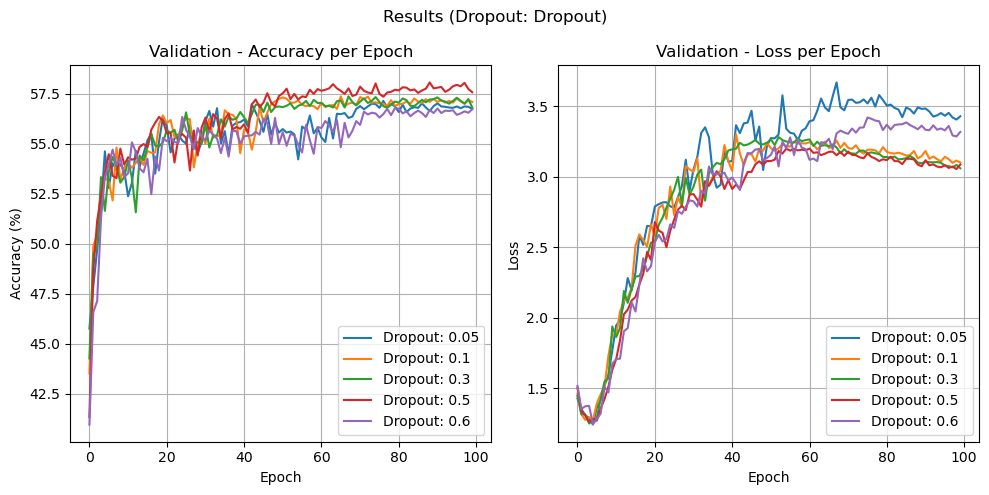

Regular Dropout Best Results {'dropout_rate': 0.5, 'validation_accuracy': [41.334262323637, 48.71973523776346, 51.14091621668699, 52.39505312663299, 53.57951576380422, 54.48528130987633, 53.40533008186727, 53.28340010451141, 54.76397840097544, 53.96272426406549, 54.32851419613308, 54.206584218777216, 54.27625849155199, 54.85107124194391, 54.990419787493465, 54.85107124194391, 55.70458108343494, 56.05295244730883, 56.349068106601635, 56.14004528827731, 55.54781396969169, 55.530395401498, 54.067235673227664, 55.30395401497997, 55.49555826511061, 55.30395401497997, 53.66660860477269, 55.66974394704755, 54.41560703710155, 55.80909249259711, 56.31423097021425, 55.600069674272774, 56.488416652151194, 56.26197526563317, 55.286535446786274, 56.24455669743947, 56.52325378853858, 55.721999651628636, 55.8439296289845, 55.756836788016024, 55.98327817453405, 55.54781396969169, 56.97613656157464, 57.21999651628636, 56.83678801602508, 57.06322940254311, 57.533530743772864, 57.06322940254311, 56.87162

In [8]:
%matplotlib inline
best_val_acc, best_drop_rate = train_and_evaluate(ResNet18_Dropout, dropout_methods['Dropout'], train_loader, val_loader, criterion, hparams, drop_method='Dropout')
best_results['Dropout'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_val_acc
}

print('Regular Dropout Best Results', best_results['Dropout'])

model = load_model(ResNet18_Dropout, best_drop_rate, 'Dropout', N)
loss, acc = evaluate_model(model,test_loader,criterion,multi_class_accuracy, 'Dropout')
print( f'Dropout Method: Dropout, Test Loss: {loss}, Test Accuracy: {acc}')


****************************************************
* Dropout method: Concrete  |  dropout rate: 0.001 *
****************************************************
Epoch [1/100]  |  Train Loss: 1.5790, Train Accuracy: 38.08%  |  Validation Loss: 1.4964, Validation Accuracy: 43.22%
----------------------------------------------------------------------------------------------------------
Epoch [2/100]  |  Train Loss: 1.3330, Train Accuracy: 48.29%  |  Validation Loss: 1.3955, Validation Accuracy: 46.80%
----------------------------------------------------------------------------------------------------------
Epoch [3/100]  |  Train Loss: 1.1763, Train Accuracy: 54.79%  |  Validation Loss: 1.3341, Validation Accuracy: 51.19%
----------------------------------------------------------------------------------------------------------
Epoch [4/100]  |  Train Loss: 1.0390, Train Accuracy: 60.53%  |  Validation Loss: 1.2217, Validation Accuracy: 52.95%
------------------------------------------------

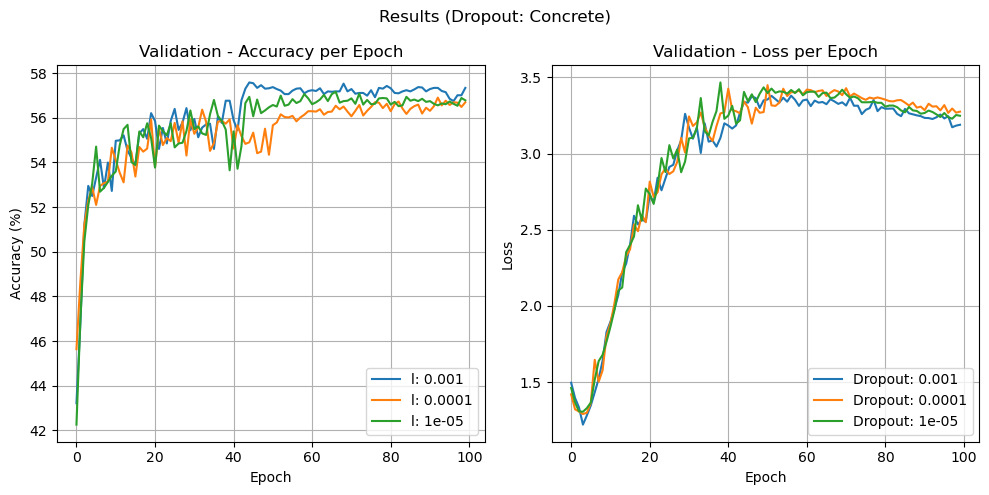

Concrete Dropout Best Results {'dropout_rate': 0.001, 'validation_accuracy': [43.215467688556004, 46.803692736457066, 51.193171921268075, 52.95244730883121, 52.49956453579516, 53.318237240898796, 54.11949137780874, 52.84793589966905, 53.99756140045288, 52.726005922313185, 54.973001219299775, 54.990419787493465, 55.2168611740115, 54.53753701445741, 54.206584218777216, 53.87563142309702, 55.30395401497997, 55.49555826511061, 55.06009406026825, 56.20971956105208, 55.861348197178195, 54.60721128723219, 55.54781396969169, 54.85107124194391, 55.861348197178195, 56.40132381118272, 55.46072112872322, 55.79167392440341, 56.43616094757011, 55.443302560529524, 55.94844103814666, 55.129768333043025, 55.565232537885386, 55.70458108343494, 55.73941821982233, 54.60721128723219, 56.05295244730883, 55.77425535620972, 56.767113743250306, 56.767113743250306, 55.89618533356558, 55.443302560529524, 56.784532311443996, 57.30708935725483, 57.58578644835394, 57.550949311966555, 57.34192649364222, 57.463856470

In [9]:
%matplotlib inline 
best_val_acc, best_drop_rate= train_and_evaluate(ResNet18_Concrete, dropout_methods['Concrete'], train_loader, val_loader, criterion, hparams, drop_method='Concrete')
best_results['Concrete'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_val_acc
}

print('Concrete Dropout Best Results', best_results['Concrete'])

model = load_model(ResNet18_Concrete, best_drop_rate, 'Concrete', N)
loss, acc = evaluate_model(model,test_loader,criterion,multi_class_accuracy,'Concrete')
print( f'Dropout Method: Concrete, Test Loss: {loss}, Test Accuracy: {acc}')


*********************************************************
* Dropout method: Variational  |  dropout rate: (-8, 2) *
*********************************************************
Epoch [1/100]  |  Train Loss: 2.1374, Train Accuracy: 39.05%  |  Validation Loss: 0.0171, Validation Accuracy: 45.03%
----------------------------------------------------------------------------------------------------------
Epoch [2/100]  |  Train Loss: 1.8193, Train Accuracy: 49.59%  |  Validation Loss: 0.0161, Validation Accuracy: 49.10%
----------------------------------------------------------------------------------------------------------
Epoch [3/100]  |  Train Loss: 1.6049, Train Accuracy: 55.50%  |  Validation Loss: 0.0153, Validation Accuracy: 52.19%
----------------------------------------------------------------------------------------------------------
Epoch [4/100]  |  Train Loss: 1.4133, Train Accuracy: 60.45%  |  Validation Loss: 0.0162, Validation Accuracy: 53.54%
---------------------------------

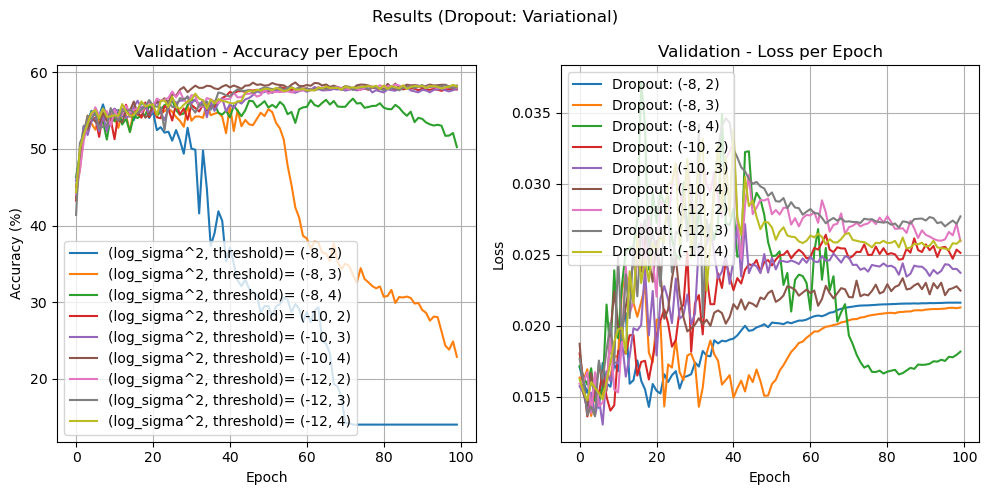

Variational Dropout Best Results {'dropout_rate': (-10, 4), 'validation_accuracy': [43.68576902978575, 49.03326946524996, 52.27312314927713, 52.53440167218255, 54.10207280961505, 53.57951576380422, 53.178888695349244, 54.816234105556525, 53.68402717296638, 53.26598153631772, 54.31109562793938, 53.68402717296638, 53.52726005922313, 54.973001219299775, 54.990419787493465, 56.192300992858385, 54.53753701445741, 55.04267549207455, 54.084654241421354, 54.520118446263716, 55.80909249259711, 56.10520815188991, 56.20971956105208, 56.610346629507056, 56.07037101550252, 57.16774081170528, 56.923880856993556, 57.74255356209719, 58.07350635777739, 57.411600766417, 57.864483539453055, 58.26511060790803, 57.968994948615226, 57.986413516808916, 58.24769203971434, 58.19543633513325, 57.89932067584044, 57.812227834871976, 58.143180630552166, 58.3522034488765, 58.03866922139, 58.282529176101725, 58.09092492597109, 57.847064971259364, 58.26511060790803, 58.299947744295416, 58.64831910816931, 58.369622017

In [10]:
%matplotlib inline
best_val_acc, best_drop_rate = train_and_evaluate(ResNet18_Variational, dropout_methods['Variational'], train_loader, val_loader, criterion, hparams, drop_method='Variational')
best_results['Variational'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_val_acc
}

print('Variational Dropout Best Results', best_results['Variational'])

model = load_model(ResNet18_Variational, best_drop_rate, 'Variational', N)
loss, acc = evaluate_model(model,test_loader,criterion,multi_class_accuracy, 'Variational')
print( f'Dropout Method: Variational, Test Loss: {loss}, Test Accuracy: {acc}')

****************************************************
* Dropout method: DropBlock  |  dropout rate: 0.05 *
****************************************************
Epoch [1/100]  |  Train Loss: 1.6061, Train Accuracy: 37.39%  |  Validation Loss: 1.4073, Validation Accuracy: 45.55%
----------------------------------------------------------------------------------------------------------
Epoch [2/100]  |  Train Loss: 1.3483, Train Accuracy: 48.36%  |  Validation Loss: 1.3263, Validation Accuracy: 49.26%
----------------------------------------------------------------------------------------------------------
Epoch [3/100]  |  Train Loss: 1.2081, Train Accuracy: 54.41%  |  Validation Loss: 1.3324, Validation Accuracy: 49.38%
----------------------------------------------------------------------------------------------------------
Epoch [4/100]  |  Train Loss: 1.0838, Train Accuracy: 59.31%  |  Validation Loss: 1.2343, Validation Accuracy: 54.29%
------------------------------------------------

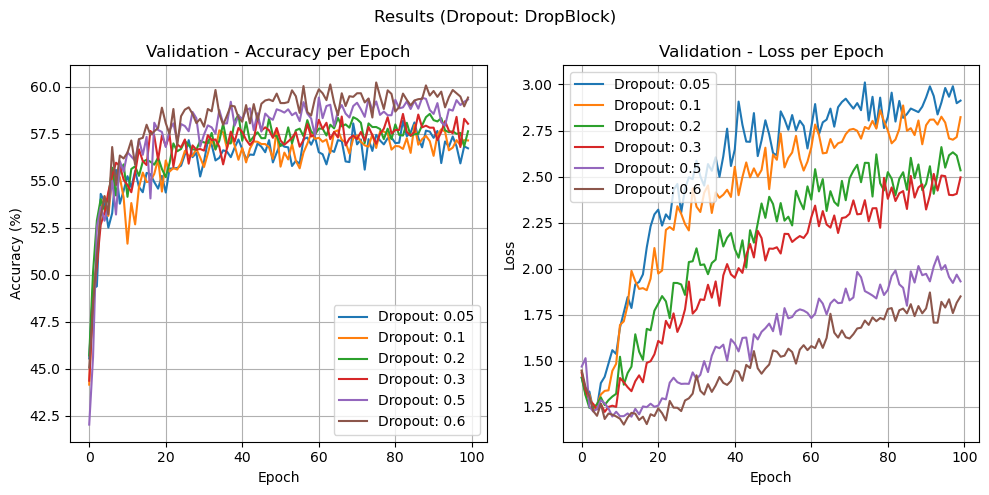

DropBlock Dropout Best Results {'dropout_rate': 0.6, 'validation_accuracy': [45.06183591708761, 48.40620101027695, 51.01898623933113, 53.09179585438077, 54.17174708238983, 53.21372583173663, 56.784532311443996, 54.76397840097544, 56.331649538407945, 56.174882424664695, 56.488416652151194, 57.13290367531789, 55.8439296289845, 57.20257794809267, 57.27225222086744, 57.968994948615226, 57.42901933461069, 57.62062358474133, 57.79480926667828, 58.87476049468734, 58.0560877895837, 57.46385647099808, 58.80508622191256, 56.87162515241247, 58.42187772165128, 58.77024908552517, 58.892179062881034, 58.54380769900714, 58.0560877895837, 58.282529176101725, 57.864483539453055, 58.80508622191256, 58.6831562445567, 59.815363177146835, 58.54380769900714, 57.968994948615226, 58.456714858038666, 58.9792719038495, 58.94443476746211, 58.3522034488765, 58.125762062358476, 59.014109040236896, 58.03866922139, 59.066364744817974, 58.19543633513325, 59.08378331301167, 59.25796899494861, 59.3102246995297, 59.2231

In [11]:
%matplotlib inline
best_val_acc, best_drop_rate = train_and_evaluate(ResNet18_DropBlock, dropout_methods['DropBlock'], train_loader, val_loader, criterion, hparams, drop_method='DropBlock')
best_results['DropBlock'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_val_acc
}

print('DropBlock Dropout Best Results', best_results['DropBlock'])

model = load_model(ResNet18_DropBlock, best_drop_rate, 'DropBlock', N)
loss, acc = evaluate_model(model,test_loader,criterion,multi_class_accuracy, 'DropBlock')
print( f'Dropout Method: DropBlock, Test Loss: {loss}, Test Accuracy: {acc}')

In [ ]:
skip_cells = True
%matplotlib inline
# optimizer = torch.optim.SGD(model.parameters(), lr=hparams.lr ,momentum=hparams.momentum, weight_decay=hparams.weight_decay, nesterov=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, hparams.scheduler_step_size, hparams.scheduler_factor, verbose=False)
# train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, hparams.epochs, drop_reg='drop_shake')
#model = ResNet18_shakedrop(depth=18, alpha=0.5, label=7).to(device) 

best_test_acc, best_drop_rate = train_and_evaluate(ShakePyramidNet, dropout_methods['DropShake'], train_loader, val_loader, criterion, hparams, drop_method='DropShake')
best_results['DropShake'] = {
    'dropout_rate': best_drop_rate,
    'validation_accuracy': best_test_acc
}

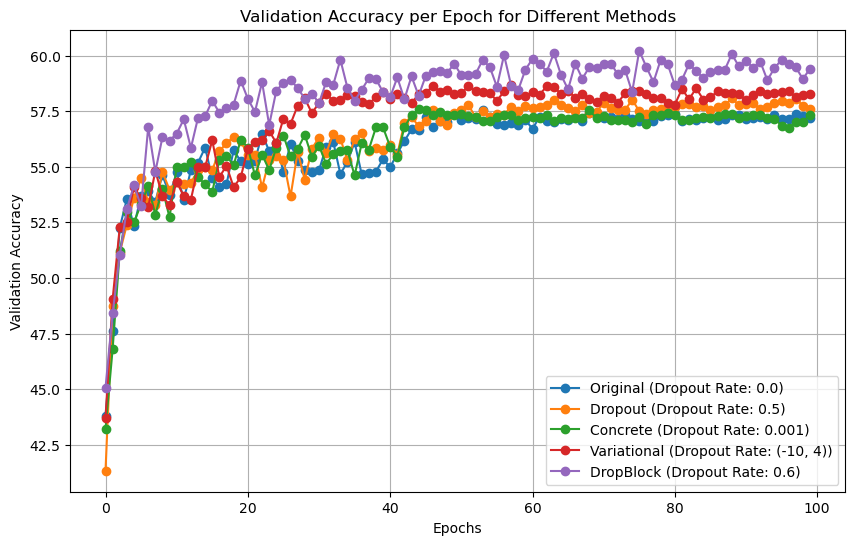

In [12]:
%matplotlib inline
plot_best_results(best_results)

test accuracy: 60.281%


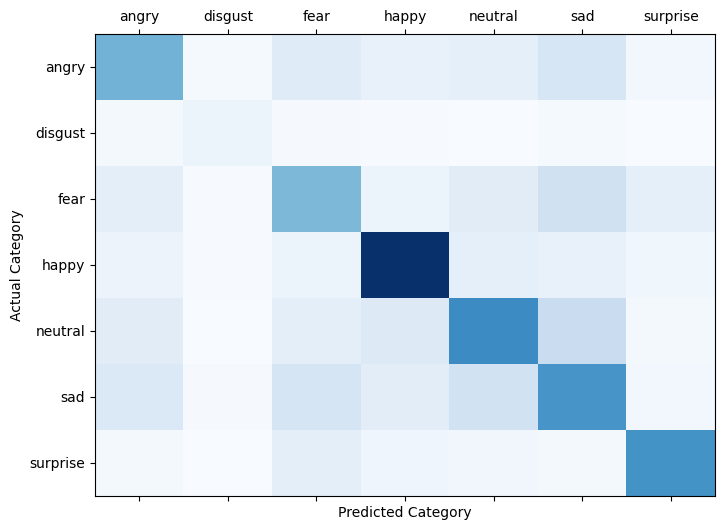

In [13]:
#choose the best method and dropout rate
best_method, best_dropout_rate = choose_best_method(best_results)

# load model, calculate accuracy and confusion matrix
model = ResNet18_Dropout().to(device)
state = torch.load(f'./checkpoints/Dropout_method[{best_method}]_dropout_rate_[{best_dropout_rate}]_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
# note: `map_location` is necessary if you trained on the GPU and want to run inference on the CPU
test_accuracy, confusion_matrix = calculate_accuracy(model, test_loader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(7), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(7), classes)
plt.show()

In [14]:
# The Fun Part - your inside out emotion

anger_image = Image.open('insideout_emotions/anger.png')
disgust_image = Image.open('insideout_emotions/disgust.png')
fear_image = Image.open('insideout_emotions/fear.png')
happy_image = Image.open('insideout_emotions/happy.png')
neutral_image = Image.open('insideout_emotions/neutral.png')
sad_image = Image.open('insideout_emotions/sad.png')
surprise_image = Image.open('insideout_emotions/surprise.png')

inside_out_emotions = [anger_image, disgust_image, fear_image, happy_image, neutral_image, sad_image, surprise_image]

transform_your_image = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    Resize((48, 48)),
    ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



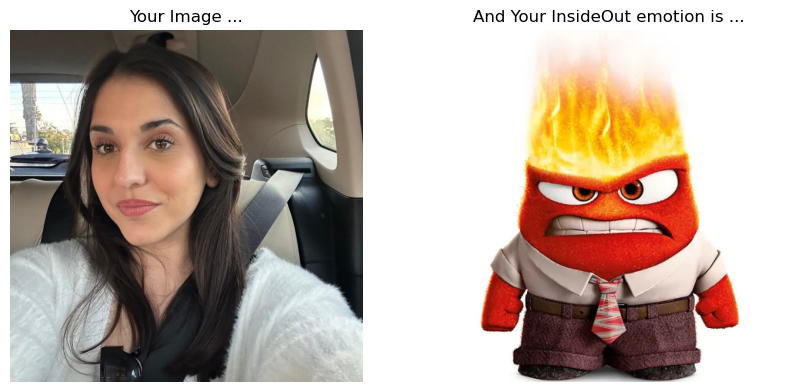

In [32]:
image_path = 'your_data/yours.jpg'
your_image_to_display = Image.open(image_path)
your_image = test_transform(your_image_to_display)
your_image = your_image.unsqueeze(0)

your_image = your_image.to(device)
your_emotion = model(your_image).to(device)

max_values, emotion_index = torch.max(your_emotion, dim=1)

%matplotlib inline
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.imshow(your_image_to_display)
plt.title('Your Image ...')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(inside_out_emotions[emotion_index])
plt.title('And Your InsideOut emotion is ...')
plt.axis("off")
plt.show()